In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd 

from pipeline.utils.tiff_to_numpy import load_SARFishProduct, load_SentinelProduct

In [2]:
SF_path = '/mnt/sasa028/cvnn4sar/SARFish/SARFish_data/raw_data/SLC/detection'
SN_path = '/mnt/sasa028/cvnn4sar/SARFish/SNAP_data/raw_data/SLC/detection'
product_name ='S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2' 

SF_product_name_vh = Path(SF_path, f'{product_name}.SAFE', 'measurement', 
                          's1b-iw2-slc-vh-20200803t075721-20200803t075746-022756-02b2ff-002_SARFish.tiff')
SF_product_name_vv = Path(SF_path, f'{product_name}.SAFE', 'measurement', 
                          's1b-iw2-slc-vv-20200803t075721-20200803t075746-022756-02b2ff-005_SARFish.tiff')

SN_product_name = Path(SN_path, 'swath_2', f'{product_name}_Orb_Cal_Deb.tif')

(SF_vv, _, _, _) = load_SARFishProduct(SF_product_name_vv)
(SF_vh, _, _, _) = load_SARFishProduct(SF_product_name_vh)

(SN_vh, SN_vv) = load_SentinelProduct(SN_product_name) 

In [3]:
def log_dB_scaling(input, lower, upper):
    return np.clip(10 * np.log10((np.abs(input) + 1e-6)**2), lower, upper)


ldB_SF_vh = log_dB_scaling(SF_vh, 20, 40)
ldB_SF_vv = log_dB_scaling(SF_vv, 20, 40)

ldB_SN_vh = log_dB_scaling(SN_vh, -30, -10)
ldB_SN_vv = log_dB_scaling(SN_vv, -30, -10)


In [4]:
targets = pd.read_csv('/mnt/sasa028/cvnn4sar/SARFish/SARFish_data/raw_data/SLC/detection/SLC_detection.csv')
targets = targets[(targets['SLC_product_identifier'] == product_name) & (targets['swath_index'] == 2) & (targets['confidence'] != "LOW") ]
print(len(targets))
fishing_vessels = targets[(targets['is_vessel']==True) & (targets['is_fishing'] == True)]
non_fishing_vessels = targets[(targets['is_vessel']==True) & (targets['is_fishing'] == False)]
non_vessels = targets[(targets['is_vessel']==False)]
print(len(fishing_vessels), len(non_fishing_vessels), len(non_vessels))



62
6 2 7


In [5]:
idx=0
fv = fishing_vessels.iloc[5]
nfv = non_fishing_vessels.iloc[0]
nv = non_vessels.iloc[0]

fv_col, fv_row = int(fv['detect_scene_column']), int(fv['detect_scene_row'])
nfv_col, nfv_row = int(nfv['detect_scene_column']), int(nfv['detect_scene_row'])
nv_col, nv_row = int(nv['detect_scene_column']), int(nv['detect_scene_row'])


fv_left, fv_right, fv_top, fv_bottom = int(fv['left']), int(fv['right']), int(fv['top']), int(fv['bottom'])
nfv_left, nfv_right, nfv_top, nfv_bottom = int(nfv['left']), int(nfv['right']), int(nfv['top']), int(nfv['bottom'])
nv_left, nv_right, nv_top, nv_bottom = int(nv['left']), int(nv['right']), int(nv['top']), int(nv['bottom'])

/tmp/ipykernel_445429/2798491679.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


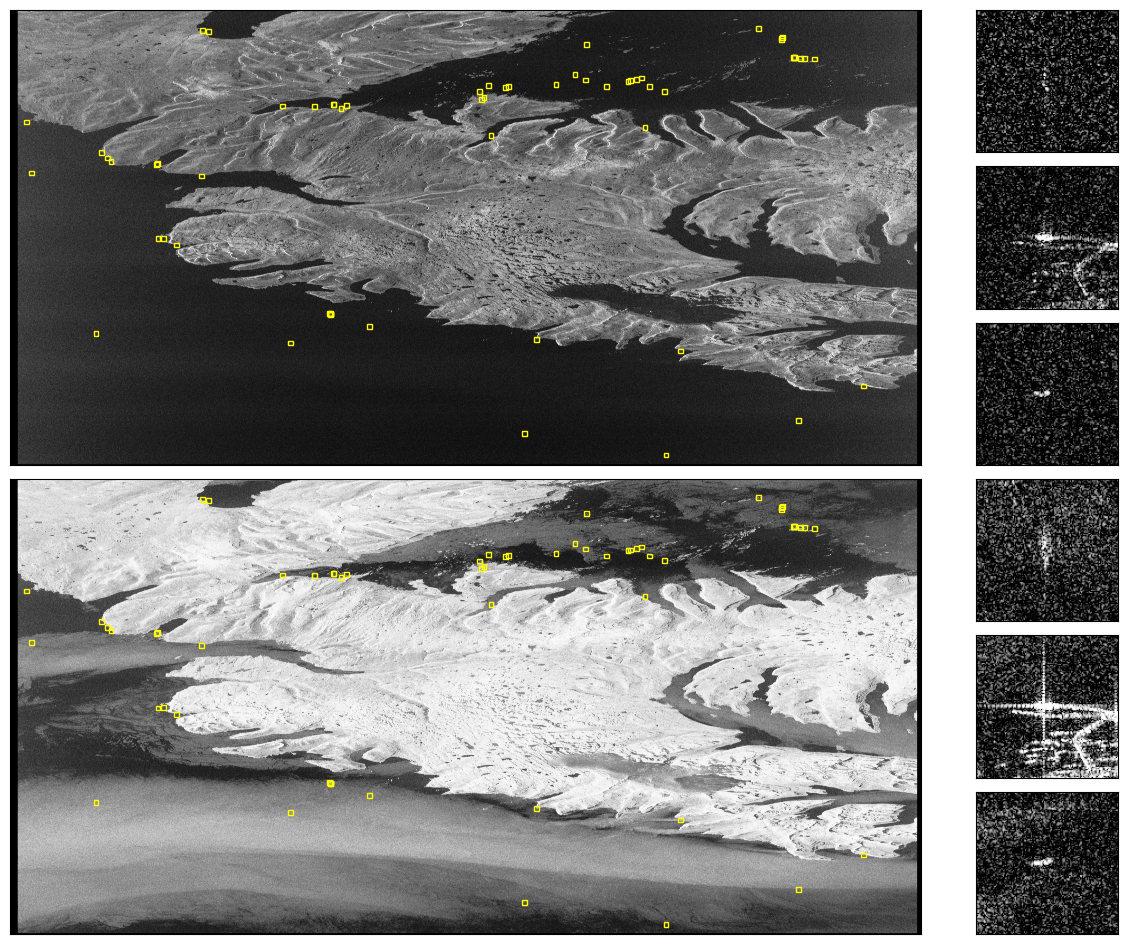

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Function to create a Rectangle from target row adjusted for the ROI
def create_rectangle(target_row, roi_x_min, roi_y_min, width=128, height=128):
    column, row = target_row['detect_scene_column'], target_row['detect_scene_row']
    left = column - width // 2
    top = row - height // 2
    
    # Adjust for the ROI
    left_adj = left - roi_y_min
    top_adj = top - roi_x_min
    
    return patches.Rectangle((left_adj, top_adj), width, height, linewidth=1, edgecolor='yellow', facecolor='none')

# Create the figure and define the grid layout
fig = plt.figure(constrained_layout=False, figsize=(15,12))
gs = fig.add_gridspec(6, 2, height_ratios=[1, 1, 1, 1, 1, 1], width_ratios=[6, 1], wspace=0, hspace=0.1)

# Main SAR image subplots
ax1 = fig.add_subplot(gs[:3, 0])
ax2 = fig.add_subplot(gs[3:, 0])

# Smaller subplots beside each main subplot
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 1])
ax6 = fig.add_subplot(gs[3, 1])
ax7 = fig.add_subplot(gs[4, 1])
ax8 = fig.add_subplot(gs[5, 1])

# Plotting images and rectangles
roi_x_min, roi_x_max = 0, ldB_SN_vh.shape[0]
roi_y_min, roi_y_max = 0, ldB_SN_vh.shape[1]
# Plot VH SAR images
ax1.imshow(ldB_SN_vh[roi_x_min:roi_x_max, roi_y_min:roi_y_max], cmap='Greys_r')
ax2.imshow(ldB_SN_vv[roi_x_min:roi_x_max, roi_y_min:roi_y_max], cmap='Greys_r')

box_width = 64
# Plot SF images with ROI
ax3.imshow(ldB_SF_vh[fv_row - box_width: fv_row + box_width , fv_col - box_width: fv_col + box_width], cmap='Greys_r')
ax4.imshow(ldB_SF_vh[nfv_row - box_width: nfv_row + box_width , nfv_col - box_width: nfv_col + box_width], cmap='Greys_r')
ax5.imshow(ldB_SF_vh[nv_row - box_width: nv_row + box_width , nv_col - box_width: nv_col + box_width], cmap='Greys_r')

ax6.imshow(ldB_SF_vv[fv_row - box_width: fv_row + box_width , fv_col - box_width: fv_col + box_width], cmap='Greys_r')
ax7.imshow(ldB_SF_vv[nfv_row - box_width: nfv_row + box_width , nfv_col - box_width: nfv_col + box_width], cmap='Greys_r')
ax8.imshow(ldB_SF_vv[nv_row - box_width: nv_row + box_width , nv_col - box_width: nv_col + box_width], cmap='Greys_r')

# Add rectangles to SAR images
for index, trow in targets.iterrows():
    rect1 = create_rectangle(trow, roi_x_min, roi_y_min, 128, 128)
    rect2 = create_rectangle(trow, roi_x_min, roi_y_min, 128, 128)

    ax1.add_patch(rect1)
    ax2.add_patch(rect2)

# Remove tick labels for subplots
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust plot limits and aspect ratios for SAR images
ax1.set_xlim(0, SN_vh.shape[1])
ax1.set_ylim(SN_vh.shape[0], 0)  # Inverted y-axis for correct image display

ax2.set_xlim(0, SN_vv.shape[1])
ax2.set_ylim(SN_vv.shape[0], 0)  # Inverted y-axis for correct image display

# Adjust layout
#plt.tight_layout()
#plt.subplots_adjust(top=0.95, bottom=0.05)

# Display the plot

#plt.savefig('sar_products_with_ships.png', dpi=300, bbox_inches='tight')
plt.show()




40.0 -10.0


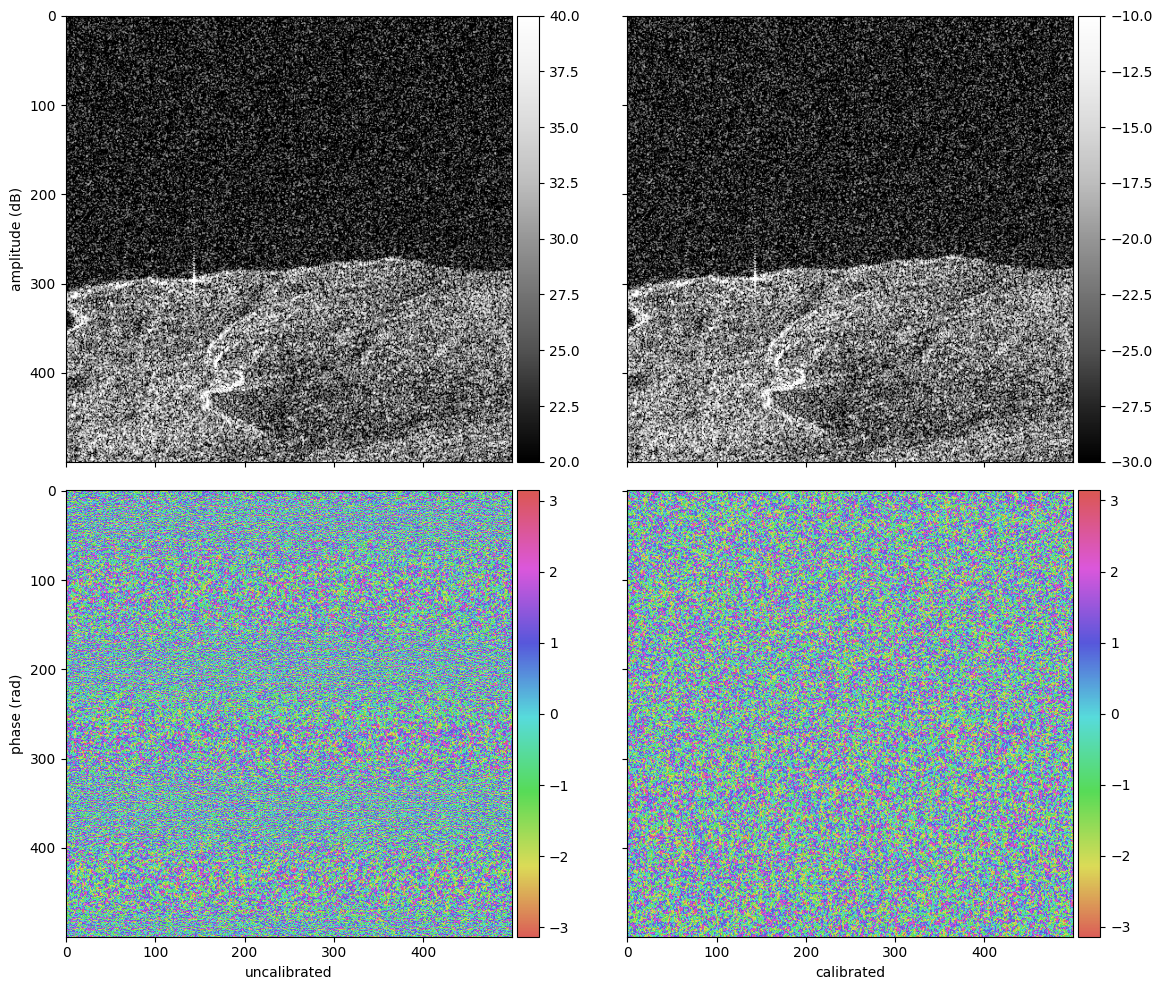

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import seaborn as sns

#Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Generate some data for the subplots
xmin, xmax, ymin, ymax= 4500, 5000, 5000, 5500
data1 = ldB_SF_vh[xmin:xmax, ymin: ymax]
data2 = ldB_SN_vh[xmin:xmax, ymin: ymax]
data3 = np.angle(SF_vh[xmin:xmax, ymin:ymax])
data4 = np.angle(SN_vh[xmin:xmax, ymin:ymax])
print(np.max(data1), np.max(data2))

sns_palette = sns.color_palette("hls", 314)  # Choose 'hsv' for cyclic nature
husl = ListedColormap(sns_palette)

# Plot data in each subplot

im1 = axs[0, 0].imshow(data1, cmap='Greys_r')
im2 = axs[0, 1].imshow(data2, cmap='Greys_r')
im3 = axs[1, 0].imshow(data3, cmap=husl)
im4 = axs[1, 1].imshow(data4, cmap=husl)

# Create colorbars for each subplot
divider1 = make_axes_locatable(axs[0, 0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)

divider2 = make_axes_locatable(axs[0, 1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)

divider3 = make_axes_locatable(axs[1, 0])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax=cax3)

divider4 = make_axes_locatable(axs[1, 1])
cax4 = divider4.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im4, cax=cax4)

axs[0,0].set_ylabel('amplitude (dB)')
axs[1,0].set_ylabel('phase (rad)')
axs[1,0].set_xlabel('uncalibrated')
axs[1,1].set_xlabel('calibrated')
plt.tight_layout()
plt.savefig('calibrated_vs_uncalibrated.png', dpi=300, bbox_inches='tight')
plt.show()